<a href="https://colab.research.google.com/github/mandarpanse/AI-Healthcare-MSAI/blob/main/MSAI_NLP_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scispacy
!pip install medSpaCy
# Clean slate setup (Google Colab or fresh notebook)
!pip install --no-cache-dir scipy==1.10.1
!pip install gensim matplotlib seaborn scikit-learN

# Download scispaCy model
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz


  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz (120.2 MB)
  Preparing metadata (setup.py) ... done
  Using cached spacy-3.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached thinc-8.1.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached spacy-3.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.4 MB)
Using cached thinc-8.1.12-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (917 kB)
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [2]:
# Install dependencies if needed
# !pip install pandas spacy scispacy gensim scikit-learn matplotlib seaborn medspacy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_ner_bc5cdr_md-0.5.1.tar.gz

import pandas as pd
import numpy as np
import re
import spacy
import scispacy
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import medspacy
from medspacy.ner import TargetMatcher
from medspacy.target_matcher import TargetMatcher
from medspacy.target_matcher.target_rule import TargetRule

nlp_med = medspacy.load()
target_matcher = TargetMatcher(nlp_med)

target_matcher.add([
    TargetRule("subarachnoid hemorrhage", "PROBLEM"),
    TargetRule("seizures", "PROBLEM"),
    TargetRule("hypertension", "PROBLEM"),
])


In [3]:
# ---------------------- Step 1: Load CSV Files ----------------------
# Update file paths as needed
notes_df = pd.read_csv('NOTEEVENTS_csv.csv')
diag_df = pd.read_csv('DIAGNOSES_ICD.csv', usecols=['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE'])


In [4]:
# ---------------------- Step 2: Filter for ICD9 Code 430 ----------------------
sah_patients = diag_df[diag_df['ICD9_CODE'] == '430']
merged = pd.merge(sah_patients, notes_df, on=['SUBJECT_ID', 'HADM_ID'])
discharge_notes_df = merged[merged['CATEGORY'] == 'Discharge summary']
discharge_notes = discharge_notes_df['TEXT'].dropna().tolist()[:10]  # Limit for speed

print(f"Loaded {len(discharge_notes)} discharge summaries for ICD9 430")


Loaded 10 discharge summaries for ICD9 430


In [5]:
# ---------------------- Step 3: Preprocessing for Word2Vec ----------------------
def preprocess_text(texts):
    processed = []
    for text in texts:
        tokens = [word.lower() for word in re.findall(r'\b\w+\b', text)]
        processed.append(tokens)
    return processed

processed_notes = preprocess_text(discharge_notes)


In [6]:
# ---------------------- Step 4: Word2Vec Embedding ----------------------
w2v_model = Word2Vec(sentences=processed_notes, vector_size=100, window=5, min_count=2, workers=4)

# Choose top N common medical terms or your own list
sample_words = ['aneurysm', 'seizures', 'headache', 'vasospasm', 'nimodipine']
valid_words = [word for word in sample_words if word in w2v_model.wv]
word_vectors = [w2v_model.wv[word] for word in valid_words]

print(word_vectors)


[array([-1.84927285e-02,  5.78333102e-02,  1.39908008e-02,  1.39073441e-02,
       -1.18577667e-02, -9.10506546e-02,  2.67417897e-02,  1.59447238e-01,
       -6.59569949e-02, -2.88627557e-02, -6.64634109e-02, -1.21074028e-01,
       -1.18084345e-02,  2.65697110e-02,  2.82746963e-02, -6.70148730e-02,
        3.09644099e-02, -9.47916657e-02, -1.03802551e-02, -1.17518425e-01,
        1.32364640e-02,  3.46228946e-03,  1.43851908e-02, -2.50090682e-03,
       -1.82104763e-02,  8.33164249e-03, -4.34153900e-02, -5.59233166e-02,
       -6.00200109e-02, -1.17757387e-04,  1.06979482e-01,  2.13020407e-02,
        3.76533009e-02, -1.02776825e-01, -2.66455654e-02,  9.68193114e-02,
        4.23264727e-02, -7.87625536e-02, -6.17034063e-02, -1.43054843e-01,
       -8.51604622e-03, -6.35221004e-02, -2.81133894e-02, -1.37957223e-02,
        5.57010472e-02, -6.22480549e-02, -5.40139638e-02, -3.67379896e-02,
        5.81058562e-02,  3.75687294e-02,  4.88977060e-02, -7.87001476e-02,
       -8.03277548e-03, 

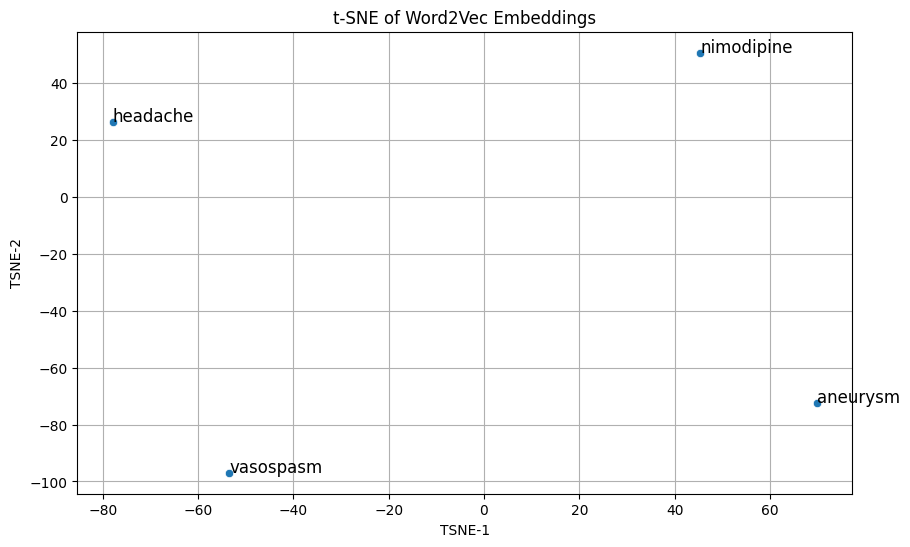

In [7]:
# Make sure word_vectors is a NumPy array
word_vectors_np = np.array(word_vectors)
# ---------------------- Step 5: t-SNE Visualization ----------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
tsne_result = tsne.fit_transform(word_vectors_np)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1])
for i, word in enumerate(valid_words):
    plt.text(tsne_result[i, 0]+0.01, tsne_result[i, 1]+0.01, word, fontsize=12)
plt.title("t-SNE of Word2Vec Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


In [8]:
# ---------------------- Step 6: scispaCy NER ----------------------
print("\n--- scispaCy Entities ---")
nlp_sci = spacy.load("en_ner_bc5cdr_md")

for note in discharge_notes[:3]:  # Limit output
    doc = nlp_sci(note)
    for ent in doc.ents:
        print(f"{ent.text:30} -> {ent.label_}")


--- scispaCy Entities ---
frontal occipital headache     -> DISEASE
seizure                        -> DISEASE
hemorrhage                     -> DISEASE
incontinence                   -> DISEASE
Anemia                         -> DISEASE
Stroke                         -> DISEASE
stroke                         -> DISEASE
Alcohol                        -> CHEMICAL
O2 nonrebreather               -> CHEMICAL
aneurysm                       -> DISEASE
vasospasms                     -> DISEASE
steroids                       -> CHEMICAL
Subarachnoid hemorrhage        -> DISEASE
aneurysm                       -> DISEASE
Nimodipine                     -> CHEMICAL
Heparin                        -> CHEMICAL
Dilantin                       -> CHEMICAL
Zantac                         -> CHEMICAL
seizure                        -> DISEASE
palpitations                   -> DISEASE
chest pain                     -> DISEASE
shortness of breath            -> DISEASE
weakness                       -> DISEASE


In [9]:
# ---------------------- Step 7: medSpaCy NER ----------------------
print("\n--- medSpaCy Entities ---")
nlp_med = medspacy.load()
target_matcher = nlp_med.get_pipe("medspacy_target_matcher")

target_matcher.add([
    TargetRule("subarachnoid hemorrhage", "PROBLEM"),
    TargetRule("seizures", "PROBLEM"),
    TargetRule("hypertension", "PROBLEM"),
    TargetRule("nimodipine", "TREATMENT"),
    TargetRule("vasospasm","PROBLEM")
])


for note in discharge_notes[:3]:  # Limit output
    doc = nlp_med(note)
    for ent in doc.ents:
        print(f"{ent.text:30} -> {ent.label_}")



--- medSpaCy Entities ---
Subarachnoid hemorrhage        -> PROBLEM
Nimodipine                     -> TREATMENT
subarachnoid hemorrhage        -> PROBLEM
Nimodipine                     -> TREATMENT
Nimodipine                     -> TREATMENT
subarachnoid hemorrhage        -> PROBLEM
subarachnoid hemorrhage        -> PROBLEM
subarachnoid hemorrhage        -> PROBLEM
Hypertension                   -> PROBLEM
hypertension                   -> PROBLEM
Subarachnoid hemorrhage        -> PROBLEM
Subarachnoid hemorrhage        -> PROBLEM
subarachnoid hemorrhage        -> PROBLEM
nimodipine                     -> TREATMENT
vasospasm                      -> PROBLEM
Nimodipine                     -> TREATMENT
Hypertension                   -> PROBLEM
nimodipine                     -> TREATMENT
Subarachnoid Hemorrhage        -> PROBLEM
seizures                       -> PROBLEM
